In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import random
from collections import defaultdict
from copy import deepcopy
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from networkx.algorithms.approximation import clique
from scipy.stats import rankdata
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm

from feature_importance import RFE_custom
from sbm_neighbour_score import sbm_neighbour_score

In [3]:
kernels_names = [
    'Katz', 'logKatz',
    'For', 'logFor',
    'Comm', 'logComm',
    'Heat', 'logHeat',
    'NHeat', 'logNHeat',
    'SCT', 'SCCT',
    'RSP', 'FE',
    'PPR', 'logPPR',
    'ModifPPR', 'logModifPPR',
    'HeatPR', 'logHeatPR',
    'DF', 'logDF',
    'Abs', 'logAbs',
    'SP-CT'
]

shuffle = lambda x: sorted(x, key=lambda k: random.random())

def dict_argmax(dct, score_key):
    best_key = list(dct.keys())[0]
    best_val = dct[best_key]
    for k, v in dct.items():
        if v[score_key] > best_val[score_key]:
            best_key, best_val = k, v
    return best_key, best_val

CACHE_ROOT = '../../cache/cache'

def load_or_calc_and_save(filename, force_calc=False, ignore_if_exist=False):
    def decorator(func):
        def wrapped(*args, **kwargs):
            if os.path.exists(filename) and not force_calc:
                print(f'{func.__name__}: cache file {filename} found! Skip calculations')
                if not ignore_if_exist:
                    with open(filename, 'rb') as f:
                        result = pickle.load(f)
                else:
                    result = None
            else:
                print(f'{func.__name__}: RECALC {filename}.\nargs: {", ".join(args)}, kwargs: {", ".join([f"{k}={v}" for k, v in kwargs.items()])}')
                result = func(*args, **kwargs)
                with open(filename, 'wb') as f:
                    pickle.dump(result, f)
            return result
        return wrapped
    return decorator

def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for dataset, classifier_accuracy in results.items():
        if type(dataset) == tuple:
            dataset = '_'.join([str(x) for x in dataset])
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

def ytrue_to_partition(y_true):
    partition = defaultdict(list)
    for idx, class_ in enumerate(y_true):
        partition[class_].append(idx)
    return list(partition.values())

In [4]:
SBM_RESULTS_ROOT = '../../cache/kkmeans_init_sbm'
columns = [
    (100, 2, 0.05, 0.001), (100, 2, 0.05, 0.002), (100, 2, 0.05, 0.005), (100, 2, 0.05, 0.007),
    (100, 2, 0.05, 0.01), (100, 2, 0.05, 0.02), (100, 2, 0.05, 0.03), (100, 2, 0.05, 0.05),
    
    (100, 2, 0.1, 0.001), (100, 2, 0.1, 0.002), (100, 2, 0.1, 0.005), (100, 2, 0.1, 0.01),
    (100, 2, 0.1, 0.02), (100, 2, 0.1, 0.03), (100, 2, 0.1, 0.05), (100, 2, 0.1, 0.07),
    (100, 2, 0.1, 0.1),
    
    (100, 2, 0.15, 0.01), (100, 2, 0.15, 0.03), (100, 2, 0.15, 0.05), (100, 2, 0.15, 0.07),
    (100, 2, 0.15, 0.1), (100, 2, 0.15, 0.15),
    
    (100, 2, 0.2, 0.05), (100, 2, 0.2, 0.1), (100, 2, 0.2, 0.15),
    
    (100, 2, 0.3, 0.05), (100, 2, 0.3, 0.1), (100, 2, 0.3, 0.15),
    
    (102, 3, 0.1, 0.001), (102, 3, 0.1, 0.005), (102, 3, 0.1, 0.01), (102, 3, 0.1, 0.02),
    (102, 3, 0.1, 0.05), (102, 3, 0.1, 0.1),
    
    (102, 3, 0.3, 0.05), (102, 3, 0.3, 0.1), (102, 3, 0.3, 0.15),
    
    (100, 4, 0.1, 0.001), (100, 4, 0.1, 0.005), (100, 4, 0.1, 0.01), (100, 4, 0.1, 0.02),
    (100, 4, 0.1, 0.05), (100, 4, 0.1, 0.1),
    
    (100, 4, 0.3, 0.1), (100, 4, 0.3, 0.15),
    
    (150, 2, 0.1, 0.001),
    
    (150, 3, 0.1, 0.001), (150, 3, 0.1, 0.005), (150, 3, 0.1, 0.01), (150, 3, 0.1, 0.02),
    (150, 3, 0.1, 0.05), (150, 3, 0.1, 0.1),
    
    (200, 2, 0.3, 0.05), (200, 2, 0.3, 0.1), (200, 2, 0.3, 0.15),
    
    (201, 3, 0.3, 0.1),
    
    (200, 4, 0.1, 0.001), (200, 4, 0.1, 0.005), (200, 4, 0.1, 0.01), (200, 4, 0.1, 0.02),
    (200, 4, 0.1, 0.05), (200, 4, 0.1, 0.1),
    
    (200, 4, 0.3, 0.1), (200, 4, 0.3, 0.15)
]

def column2str(column):
    n, k, p_in, p_out = column
    return f'{n}_{k}_{p_in:.2f}_{p_out:.3f}'

datasets = [column2str(x) for x in columns]

In [5]:
with open(f'{CACHE_ROOT}/sbm_inits_bestparam_byari_individual.pkl', 'rb') as f:
    results = pickle.load(f)  # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
with open(f'{CACHE_ROOT}/sbm_modularity.pkl', 'rb') as f:
    modularity_results = pickle.load(f)  # {(dataset, graph_idx): modularity}
    
for key in list(results.keys()):
    if key[0] not in datasets:
        del results[key]
        
for key in list(results.keys()):
    if key[0] not in datasets:
        del modularity_results[key]

In [6]:
results_modularity_any3 = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # {dataset: {graphidx: {kernel_name: best_ari}}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[dataset][graph_idx][kernel_name] = si_ari['modularity_any3']

In [7]:
def extract_feature(dataset_name, feature, G, partition, sp, max_clique):
    # graph-independent features
    n, k, p_in, p_out = [float(x) for x in dataset_name.split('_')]
    if feature == 'n':
        return n
    elif feature == 'k':
        return k
    elif feature == 'p_in':
        return p_in
    elif feature == 'p_out':
        return p_out
    elif feature == 'n/k':
        return n / k
    elif feature == 'p_in/p_out':
        return p_in / p_out
    
    elif feature == 'log(n)':
        return n
    elif feature == 'log(k)':
        return k
    elif feature == 'log(p_in)':
        return p_in
    elif feature == 'log(p_out)':
        return p_out
    elif feature == 'log(n/k)':
        return n / k
    elif feature == 'log(p_in/p_out)':
        return p_in / p_out
    
    elif feature == 'n/k * p_in/p_out':
        return (n / k) * (p_in / p_out)
    elif feature == 'log(n)/k * p_in/p_out':
        return np.log(n) / k * (p_in / p_out)
    elif feature == 'log(n/k) * p_in/p_out':
        return np.log(n / k) * (p_in / p_out)
    elif feature == 'log(n/k * p_in/p_out)':
        return np.log((n / k) * (p_in / p_out))
    
    elif feature == 'sbm_neighbour_score':
        return sbm_neighbour_score(int(n), int(k), p_in, p_out)
    
    # graph-dependant features
    elif feature == 'modularity':
        return nx.community.modularity(G, partition)
    elif feature == 'diameter':
        return nx.diameter(G)
    elif feature == 'density':
        return nx.density(G)
    elif feature == 'avg_deg':
        return np.mean(G.degree)
    elif feature == 'std_deg':
        return np.std(G.degree)
    elif feature == 'avg(deg | deg > avg_deg)':
        deg = np.array(G.degree)
        return np.mean(deg[deg > np.mean(deg)])
    elif feature == 'median_deg':
        return np.median(G.degree)
    elif feature == 'max_deg':
        return np.max(G.degree)
    elif feature == 'avg_sp':
        return nx.average_shortest_path_length(G)
    elif feature == 'std_sp':
        return np.std(sp)
    elif feature == 'median_sp':
        return np.median(sp)
    elif feature == 'max_sp':
        return np.max(sp)
    elif feature == 'max_clique':
        return max_clique
    elif feature == 'max_clique/(n/k)':
        return max_clique/(n/k)
    else:
        raise Exception()

# Feature importance

In [8]:
feature_names = [
    'n', 'k', 'p_in', 'p_out', 'n/k', 'p_in/p_out',
    'log(n)/k * p_in/p_out', 'n/k * p_in/p_out', 'log(n/k) * p_in/p_out', 'log(n/k * p_in/p_out)',
    'sbm_neighbour_score',
    'modularity', 'diameter', 'density', 
    'avg_deg', 'std_deg', 'avg(deg | deg > avg_deg)', 'median_deg', 'max_deg',
    'avg_sp', 'std_sp', 'median_sp', 'max_sp', 
    'max_clique', 'max_clique/(n/k)'
]

allowed_features = list({
    'n': False,
    'k': False,
    'p_in': False,
    'p_out': False,
    'n/k': True,
    'p_in/p_out': True,
    'log(n)/k * p_in/p_out': True,
    'n/k * p_in/p_out': True,
    'log(n/k) * p_in/p_out': True,
    'log(n/k * p_in/p_out)': False,
    'sbm_neighbour_score': True,
    'modularity': True,
    'diameter': True,
    'density': True, 
    'avg_deg': True,
    'std_deg': True,
    'avg(deg | deg > avg_deg)': True,
    'median_deg': True,
    'max_deg': False,
    'avg_sp': True,
    'std_sp': True,
    'median_sp': True, 
    'max_sp': False, 
    'max_clique': True,
    'max_clique/(n/k)': True
}.values())

features_to_log = list({
    'n': False,
    'k': False,
    'p_in': False,
    'p_out': False,
    'n/k': False,
    'p_in/p_out': True,
    'log(n)/k * p_in/p_out': True,
    'n/k * p_in/p_out': True,
    'log(n/k) * p_in/p_out': True,
    'log(n/k * p_in/p_out)': False,
    'sbm_neighbour_score': False,
    'modularity': False,
    'diameter': True,
    'density': True, 
    'avg_deg': True,
    'std_deg': True,
    'avg(deg | deg > avg_deg)': True,
    'median_deg': True,
    'max_deg': True,
    'avg_sp': True,
    'std_sp': True,
    'median_sp': True, 
    'max_sp': True, 
    'max_clique': True,
    'max_clique/(n/k)': True
}.values())

In [9]:
def prepare_column(column):
    @load_or_calc_and_save(f'{CACHE_ROOT}/feature_importance/{column}.pkl')
    def wrapper():
        X, ya, yr = [], [], []
        filename = f'{column}_100_graphs.pkl'
        with open(f'{SBM_RESULTS_ROOT}/graphs/{filename}', 'rb') as f:
            data = pickle.load(f)
        for graph_idx in range(100):
            try:
                (A, y_true), _ = data[graph_idx]
            except:
                (A, y_true) = data[graph_idx]
            G = nx.from_numpy_matrix(A)
            partition = ytrue_to_partition(y_true) 
            sp = [l for u in G for v, l in nx.single_source_shortest_path_length(G, u).items()]
            max_clique = len(clique.max_clique(G))
            features = [extract_feature(column, feature_name, G, partition, sp, max_clique) for feature_name in feature_names]
            graph_ari = [v for k, v in sorted(list(results_modularity_any3[column][graph_idx].items()), key=lambda x: x[0])]
            graph_ranks = calc_avranks({0: results_modularity_any3[column][graph_idx]})[0]

            X.append(features)
            ya.append(graph_ari)
            yr.append(graph_ranks)
        return X, ya, yr
    
    return wrapper()
    
Xy_list = Parallel(n_jobs=1)(delayed(prepare_column)(column) for column in tqdm(results_modularity_any3.keys()))

X, y, X_train, y_train, X_val, y_val = [], [], [], [], [], []
for Xi, _, yi in Xy_list:
    Xi = np.array(Xi)
    for i in range(25):
        Xi[:, i] = np.log(Xi[:, i]) if features_to_log[i] else Xi[:, i]
    Xi = Xi[:, allowed_features]
    yi = yi > (np.max(yi, axis=1, keepdims=True) - 0.0001)
    
    # add one-hot encoding of features
    for i in range(25):
        feature_onehot = np.zeros((100, 25))
        feature_onehot[:, i] = 1
        Xif = np.concatenate([Xi, feature_onehot], axis=1)
        X.extend(Xif)
        y.extend(yi[:, i])
        X_train.extend(Xif[:70])
        y_train.extend(yi[:70, i])
        X_val.extend(Xif[70:])
        y_val.extend(yi[70:, i])
X, y, X_train, y_train, X_val, y_val = np.array(X), np.array(y), np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)
        
feature_names = list(np.array(feature_names)[allowed_features])

for i, name in enumerate(feature_names):
    was_logged = np.array(features_to_log)[allowed_features][i]
    X[:, i] = ((X[:, i] - np.mean(X[:, i])) if was_logged else X[:, i]) / np.std(X[:, i])
    X_train[:, i] = ((X_train[:, i] - np.mean(X_train[:, i])) if was_logged else X_train[:, i]) / np.std(X_train[:, i])
    X_val[:, i] =((X_val[:, i] - np.mean(X_val[:, i])) if was_logged else X_val[:, i]) / np.std(X_val[:, i])

feature_names += [f'kernel_{name}' for name in kernels_names]

assert X.shape[1] == len(feature_names)

wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.001.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.002.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.005.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.007.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.010.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.020.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.030.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.05_0.050.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.10_0.001.pkl found! Skip calculations
wrapper: cache file ../../cache/cache/feature_importance/100_2_0.10_0.002

In [10]:
X.shape

(162500, 43)

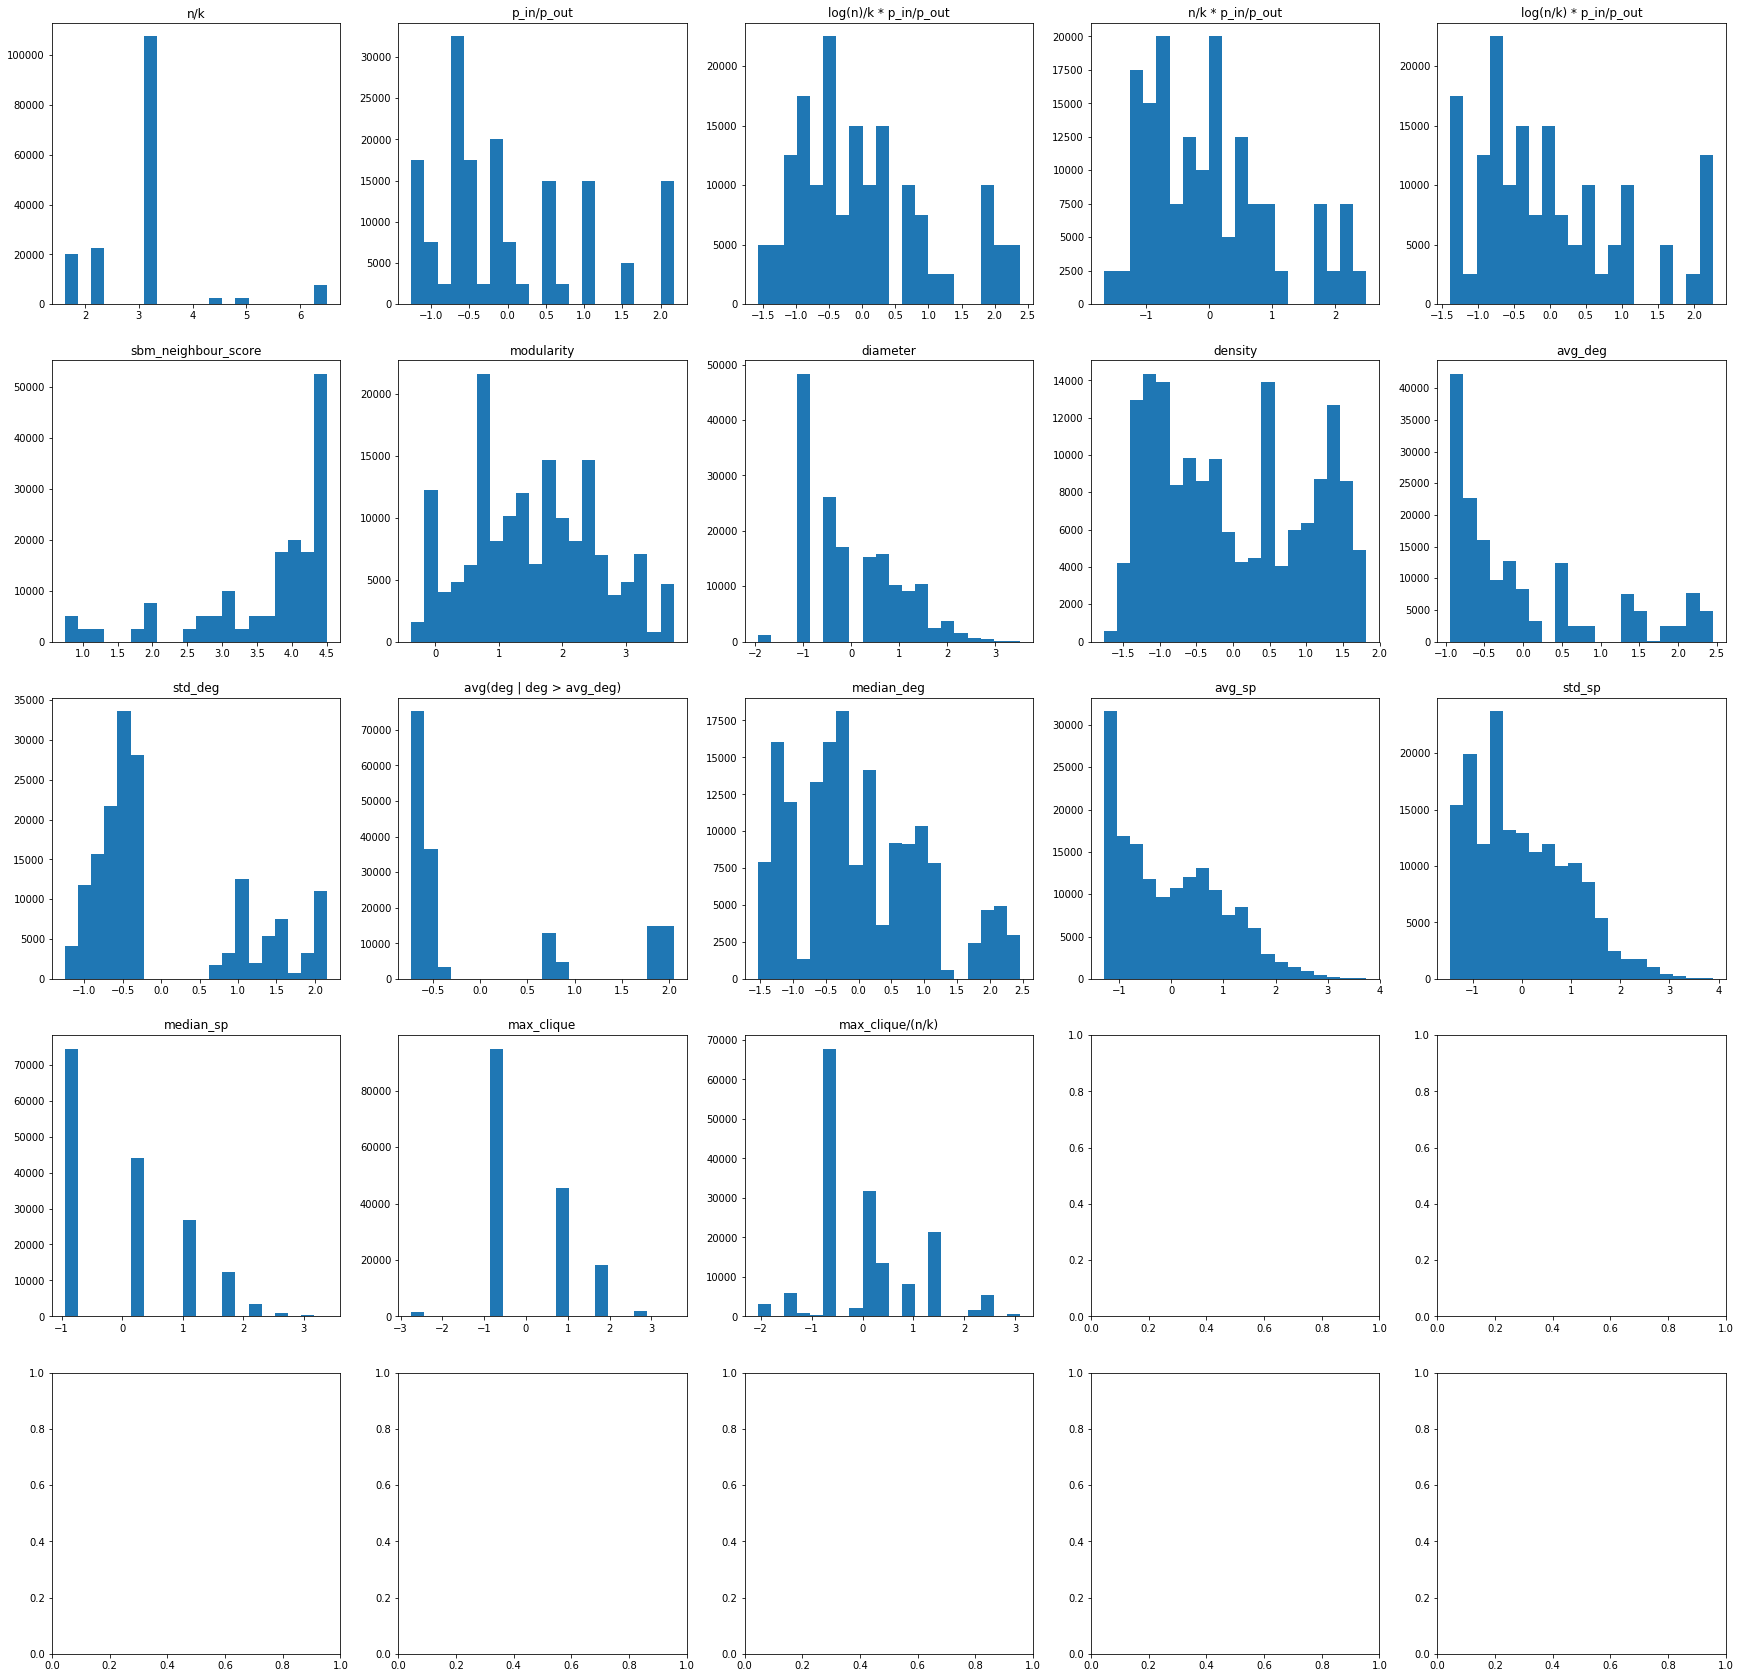

In [11]:
fig, ax = plt.subplots(5, 5, figsize=(30, 30))
ax = ax.ravel()
for i, name in enumerate(feature_names[:-25]):
    ax[i].hist(X[:, i], bins=20)
    ax[i].set_title(name)

In [12]:
estimator = LogisticRegression(max_iter=10000)
estimator.fit(X_train, y_train)
pd.DataFrame([{'feature': k, 'importance': v} for k, v in sorted(zip(feature_names, estimator.coef_[0]), key=lambda x: -np.abs(x[1]))])

,feature,importance
0,density,3.654884
1,std_deg,2.383099
2,modularity,2.370944
3,avg_deg,-2.195659
4,kernel_logHeat,-1.871255
5,max_clique/(n/k),-1.348178
6,sbm_neighbour_score,-1.036980
7,max_clique,0.941439
8,kernel_logComm,0.864229
9,kernel_For,-0.815379


In [13]:
np.argmax([0, 4, 2])

1

In [14]:
class RFE_custom:
    def __init__(self, estimator, max_features=5):
        self.estimator = estimator
        self.max_features = max_features
        
    def fit(self, X_train, y_train, X_val, y_val, names):
        # for all features first:
        estimator = deepcopy(self.estimator)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_val)
        acc_all = accuracy_score(y_val.ravel(), y_pred.ravel())
        f1_all = f1_score(y_val.ravel(), y_pred.ravel())
        print(f'all features, acc={acc_all:.3f}, f1={f1_all:.3f}')
        
        for n_features in range(1, self.max_features):
            best_n_feat, best_acc, best_f1 = None, 0, 0
            for set_feat_names in tqdm(list(combinations(names[:-25], n_features))):
                support = np.array([x in set_feat_names for x in names[:-25]] + [1] * 25, dtype=np.bool)
                estimator = deepcopy(self.estimator)
                estimator.fit(X_train[:, support], y_train)
                y_pred = estimator.predict(X_val[:, support])
                acc = accuracy_score(y_val.ravel(), y_pred.ravel())
                f1 = f1_score(y_val.ravel(), y_pred.ravel())
                if f1 > best_f1:
                    best_n_feat, best_acc, best_f1 = set_feat_names, acc, f1
            print(f'{n_features} features, set={best_n_feat} acc={best_acc:.3f}, f1={best_f1:.3f}')
        
        return self

In [15]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE_custom(estimator)  # , n_features_to_select=3, verbose=1
selector = selector.fit(X_train, y_train, X_val, y_val, feature_names)
print(list(zip(feature_names, selector.support_)))
print(list(zip(feature_names, selector.ranking_)))

all features, acc=0.856, f1=0.727
1 features, set=('sbm_neighbour_score',) acc=0.816, f1=0.640
2 features, set=('log(n)/k * p_in/p_out', 'density') acc=0.844, f1=0.694
3 features, set=('log(n)/k * p_in/p_out', 'density', 'median_sp') acc=0.849, f1=0.707
4 features, set=('p_in/p_out', 'log(n)/k * p_in/p_out', 'modularity', 'density') acc=0.851, f1=0.719


AttributeError: 'RFE_custom' object has no attribute 'support_'

In [ ]:
support = selector.support_.copy()
support[-25:] = 1
pd.DataFrame(zip(feature_names, support, selector.ranking_), columns=['feature', 'to choose', 'rank']).sort_values('rank')

In [ ]:
# all features
estimator = LogisticRegression(max_iter=10000)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_val)

acc = accuracy_score(y_val.ravel(), y_pred.ravel())
f1 = f1_score(y_val.ravel(), y_pred.ravel())
                     
print(f'acc: {acc:.2f}')
print(f'f1: {f1:.2f}')

In [ ]:
# top
estimator = LogisticRegression(max_iter=10000)
estimator.fit(X_train[:, support], y_train)
y_pred = estimator.predict(X_val[:, support])

acc = accuracy_score(y_val.ravel(), y_pred.ravel())
f1 = f1_score(y_val.ravel(), y_pred.ravel())
                     
print(f'acc: {acc:.2f}')
print(f'f1: {f1:.2f}')